In [1]:
import os

os.path.abspath('.')

'/home/panayot/Documents/site_similarity/notebooks/label_propagation'

In [2]:
import sys,os
sys.path.append("/home/panayot/Documents/site_similarity/")

In [3]:
from utils.notebook_utils import load_level_data, _DATA_PATH, load_corpus, load_json

In [4]:
lvl_zero_2018 = load_level_data(data_path=os.path.join(_DATA_PATH, 'corpus_2018_audience_overlap_sites_scrapping_result.json'), level=0)

Loaded 1062 nodes with records level <= 0 and child size:4837


In [5]:
node_embeddings = load_json(os.path.join(_DATA_PATH, 'features/corpus_2018_mixed_unweighted_512D.json'))

In [6]:
list(node_embeddings.keys())[:10]

['villagevoice.com',
 'insideclimatenews.org',
 'fury.news',
 'now8news.com',
 'constitution.com',
 'freebeacon.com',
 'brexitcentral.com',
 'foreignpolicynews.org',
 'patriotpost.us',
 'loser.com']

In [8]:
import csv

with open(os.path.join(_DATA_PATH, 'annotated_data', 'corpus_2018.tsv')) as f:
    corpus = [row for row in csv.DictReader(f, delimiter='\t')]


In [11]:
corpus[0]

OrderedDict([('source_url', 'http://www.villagevoice.com/'),
             ('source_url_normalized', 'villagevoice.com'),
             ('ref', 'http://mediabiasfactcheck.com/the-village-voice/'),
             ('fact', 'high'),
             ('bias', 'left')])

In [12]:
corpus_sites = [x['source_url_normalized'] for x in corpus]
for site in node_embeddings.keys():
    if site not in corpus_sites:
        print(site)

In [15]:
corpus[0]

OrderedDict([('source_url', 'http://www.villagevoice.com/'),
             ('source_url_normalized', 'villagevoice.com'),
             ('ref', 'http://mediabiasfactcheck.com/the-village-voice/'),
             ('fact', 'high'),
             ('bias', 'left')])

In [16]:
label2int = {
    "fact": {"low": 0, "mixed": 1, "high": 2},
    "bias": {"left": 0, 'extreme-left': 0,
                "center": 1, 'right-center': 1, 'left-center': 1,
                "right": 2, 'extreme-right': 2},
}

In [17]:
import numpy as np

In [18]:
X = np.array([node_embeddings[x['source_url_normalized']] for x in corpus])
y = np.array([label2int['fact'][x['fact']] for x in corpus])

In [ ]:
edges = [x['source_url_normalized'] for x in corpus]

In [19]:
X

array([[-0.34096959,  0.35926202, -0.0882498 , ..., -0.02311002,
        -0.00985753,  0.1010508 ],
       [ 0.03435716,  0.01916088, -0.00261393, ...,  0.22408086,
        -0.11676402,  0.21506029],
       [ 0.19366015, -0.250287  ,  0.14274631, ...,  0.37512803,
        -0.18160188, -0.01118576],
       ...,
       [-0.01856155, -0.01490556,  0.18402852, ...,  0.14545521,
        -0.19052453, -0.04112002],
       [-0.12117273,  0.70922327, -0.07649349, ..., -0.07184593,
         0.14886168, -0.10773012],
       [ 0.05576349,  0.12709758, -0.22507444, ...,  0.00608367,
        -0.4603337 ,  0.19369537]])

In [38]:
edges = [{'source': key, 'target': target['url']} for key in lvl_zero_2018 for target in lvl_zero_2018[key]['overlap_sites']]

In [39]:
edges[:10]

[{'source': 'villagevoice.com', 'target': 'nylon.com'},
 {'source': 'villagevoice.com', 'target': 'slantmagazine.com'},
 {'source': 'villagevoice.com', 'target': 'gothamist.com'},
 {'source': 'villagevoice.com', 'target': 'screendaily.com'},
 {'source': 'villagevoice.com', 'target': 'amny.com'},
 {'source': 'insideclimatenews.org', 'target': 'wri.org'},
 {'source': 'insideclimatenews.org', 'target': 'carbonbrief.org'},
 {'source': 'insideclimatenews.org', 'target': 'oneonta.edu'},
 {'source': 'insideclimatenews.org', 'target': 'skepticalscience.com'},
 {'source': 'insideclimatenews.org', 'target': 'ucsusa.org'}]

In [43]:
import stellargraph as stl
import pandas as pd

In [44]:
graph = stl.StellarGraph(edges=pd.DataFrame(edges))

In [46]:
from utils.notebook_utils import draw_graph

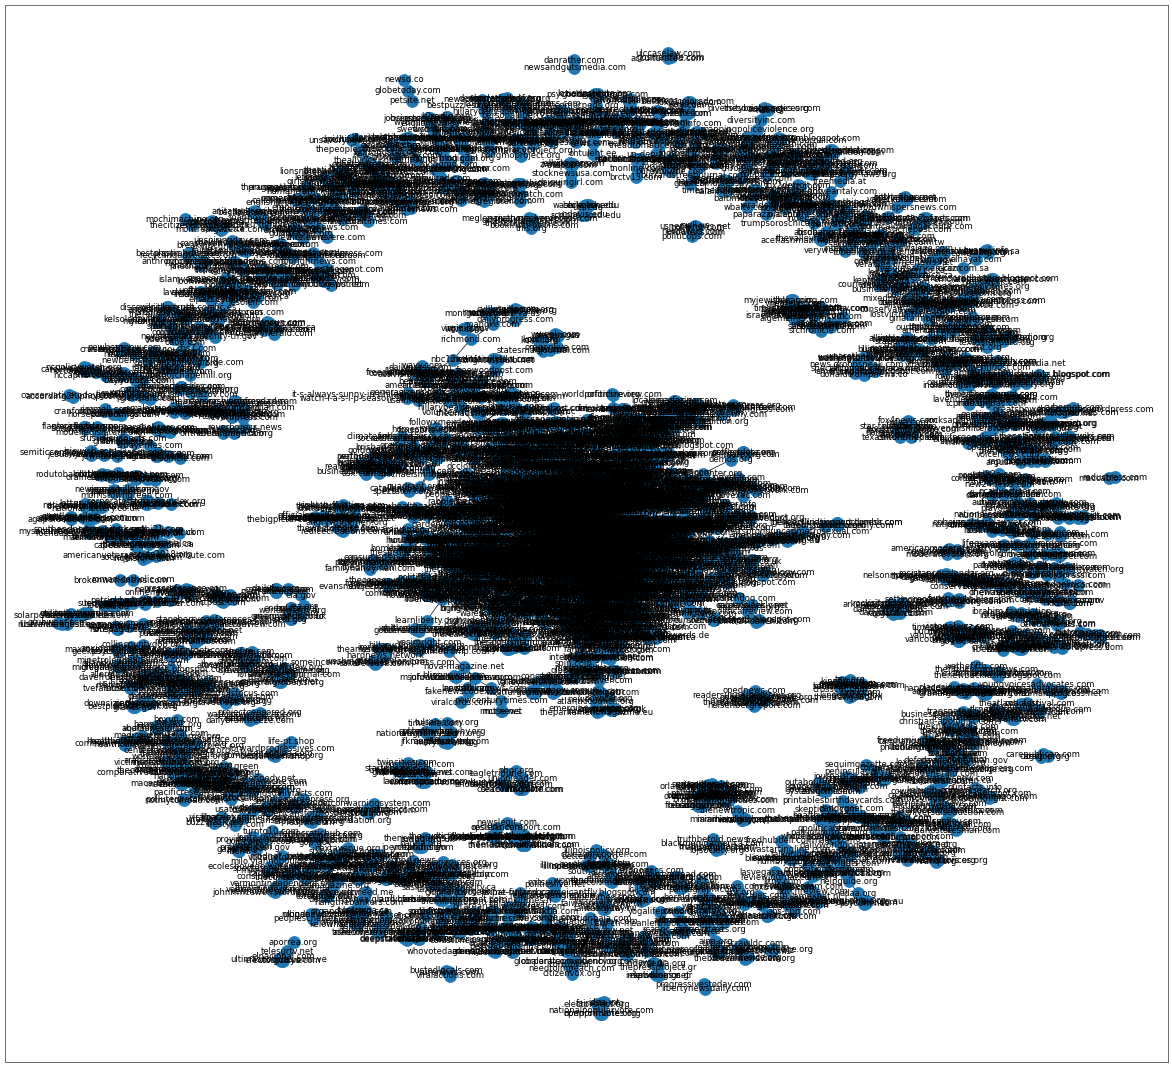

In [47]:
draw_graph(graph=graph) 

In [58]:
adjacency_matrix = graph.to_adjacency_matrix()

In [59]:
adjacency_matrix

<4175x4175 sparse matrix of type '<class 'numpy.float32'>'
	with 9308 stored elements in Compressed Sparse Row format>

In [50]:
import numpy as np
from numpy.linalg import inv

Dinv = inv(adjacency_matrix)

S = Dinv * adjacency_matrix

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

In [41]:
# evaluate label propagation on the semi-supervised learning dataset
from numpy import concatenate
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelPropagation
# define dataset


# X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=1)
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1, stratify=y)
# split train into labeled and unlabeled
X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_train, y_train, test_size=0.50, random_state=1, stratify=y_train)
# create the training dataset input
X_train_mixed = concatenate((X_train_lab, X_test_unlab))
# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_test_unlab))]
# recombine training dataset labels
y_train_mixed = concatenate((y_train_lab, nolabel))
# define model
model = LabelPropagation()
# fit model on training dataset
model.fit(X_train_mixed, y_train_mixed)
# make predictions on hold out test set
yhat = model.predict(X_test)
# calculate score for test set
score = accuracy_score(y_test, yhat)
# summarize score
print('Accuracy: %.3f' % (score*100))

/home/panayot/anaconda3/envs/site_similarity/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:281: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Accuracy: 24.015


/home/panayot/anaconda3/envs/site_similarity/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:292: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning


In [42]:

# get labels for entire training dataset data
tran_labels = model.transduction_

In [43]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

# params_svm = [dict(kernel=["rbf"], gamma=np.logspace(-6, 1, 8), C=np.logspace(-2, 2, 5))]

# # fine-tune the model
# clf_cv = GridSearchCV(SVC(), scoring="f1_macro", cv=    , n_jobs=4, param_grid=params_svm)
# clf_cv.fit(X["train"], y["train"])

# # train the final classifier using the best parameters during crossvalidation
# clf = SVC(
#     kernel=clf_cv.best_estimator_.kernel,
#     gamma=clf_cv.best_estimator_.gamma,
#     C=clf_cv.best_estimator_.C,
#     probability=True
# 		)


# define supervised learning model
model2 = LogisticRegression()

# fit supervised learning model on entire training dataset
model2.fit(X_train_mixed, tran_labels)
# make predictions on hold out test set
yhat = model2.predict(X_test)
# calculate score for test set
score = accuracy_score(y_test, yhat)
# summarize score
print('Accuracy: %.3f' % (score*100))

Accuracy: 39.024


/home/panayot/anaconda3/envs/site_similarity/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [47]:
# evaluate logistic regression fit on label propagation for semi-supervised learning
from numpy import concatenate
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.semi_supervised import LabelPropagation
from sklearn.linear_model import LogisticRegression
# define dataset
# X, y = make_classification(n_samples=1000, n_features=2, n_informative=2, n_redundant=0, random_state=1)
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=1, stratify=y)
# split train into labeled and unlabeled
X_train_lab, X_test_unlab, y_train_lab, y_test_unlab = train_test_split(X_train, y_train, test_size=0.50, random_state=1, stratify=y_train)
# create the training dataset input
X_train_mixed = concatenate((X_train_lab, X_test_unlab))
# create "no label" for unlabeled data
nolabel = [-1 for _ in range(len(y_test_unlab))]
# recombine training dataset labels
y_train_mixed = concatenate((y_train_lab, nolabel))
# define model
model = LabelPropagation()
# fit model on training dataset
model.fit(X_train_mixed, y_train_mixed)
# get labels for entire training dataset data
tran_labels = model.transduction_
# define supervised learning model
model2 = LogisticRegression()
# fit supervised learning model on entire training dataset
model2.fit(X_train_mixed, tran_labels)
# make predictions on hold out test set
yhat = model2.predict(X_test)
# calculate score for test set
score = accuracy_score(y_test, yhat)
# summarize score
print('Accuracy: %.3f' % (score*100))

/home/panayot/anaconda3/envs/site_similarity/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:281: RuntimeWarning: invalid value encountered in true_divide
  self.label_distributions_ /= normalizer


Accuracy: 39.024


/home/panayot/anaconda3/envs/site_similarity/lib/python3.7/site-packages/sklearn/semi_supervised/_label_propagation.py:292: ConvergenceWarning: max_iter=1000 was reached without convergence.
  category=ConvergenceWarning
/home/panayot/anaconda3/envs/site_similarity/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
